In [23]:
import tensorflow as tf
from keras.optimizer_v1 import SGD
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt

In [24]:
# OCT images of 1024 x 1024 pixels with 1 channel
IMG_ROWS=224; IMG_COLS=224; IMG_CHANNELS=1
IMAGE_SIZE = [IMG_ROWS, IMG_COLS]


In [25]:
WHICH_MODEL = 'DenseNet121'

if WHICH_MODEL == 'VGG16':
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1], and IMAGE_SIZE + [3] = [224, 224, 3]
    orig_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG16_oct_minipigs.h5'

elif WHICH_MODEL == 'VGG19':
    from keras.applications.vgg19 import VGG19
    from keras.applications.vgg19 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1]
    orig_model = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG19_oct_minipigs.h5'

elif WHICH_MODEL == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input

    orig_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.001
    OCT_MODEL_NAME = 'ResNet50_oct_minipigs.h5'

elif WHICH_MODEL == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input

    orig_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'InceptionV3_oct_minipigs.h5'

elif WHICH_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121
    from keras.applications.densenet import preprocess_input

In [26]:
orig_model = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
LEARN_RATE = 0.0001
OCT_MODEL_NAME = 'DenseNet121_oct_minipigs.h5'


In [27]:
BATCH_SIZE = 32

EPOCHS = 100

In [28]:
# path to TRAINING dataset of the OCT images
TRAIN_PATH = 'C:\\Users\\Ali\Documents\\minipigs_images\\Split_Data\\train'

# path to VALIDATE dataset of the OCT images
VALID_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_images\\Split_Data\\val'

# path to TESTING dataset of the OCT images
TEST_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_images\\Split_Data\\test'

DATASET = 'Minipigs'

CLASS_MODE = 'categorical'   # binary, categorical

NUMBER_OF_CLASSES = 5


In [29]:

adam = Adam(learning_rate=LEARN_RATE)
#adam = Adam(learning_rate=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', decay=LEARN_RATE/EPOCHS)

#sgd = SGD(learning_rate=LEARN_RATE)

OPTIMISATION = adam  # SGD

# no need to train the weights again
for layer in orig_model.layers[:-15]:
    layer.trainable = False

In [30]:
# to retrieve the number of classes
folders = glob(TRAIN_PATH + '/*')

In [31]:
# more layers could be added to the model
x = Flatten()(orig_model.output)
x = Dropout(0.2)(x)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=orig_model.input, outputs=prediction)

In [32]:
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

conv4_block16_0_bn (BatchNormal (None, 14, 14, 736)  2944        conv4_block15_concat[0][0]       
__________________________________________________________________________________________________
conv4_block16_0_relu (Activatio (None, 14, 14, 736)  0           conv4_block16_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block16_1_conv (Conv2D)   (None, 14, 14, 128)  94208       conv4_block16_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block16_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block16_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block16_1_relu (Activatio (None, 14, 14, 128)  0           conv4_block16_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc

In [33]:
# tell the model what cost and optimisation method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMISATION,
    metrics=['accuracy']
)

In [34]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [35]:
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 210 images belonging to 5 classes.


In [36]:
valid_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [37]:
valid_set = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 60 images belonging to 5 classes.


In [38]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 35 images belonging to 5 classes.


In [39]:
# fit the model
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=EPOCHS,
    steps_per_epoch=len(training_set),
#    validation_split=0.1
    validation_steps=len(valid_set)
)

Epoch 1/100
7/7 [==============================] - 87s 8s/step - loss: 2.5574 - accuracy: 0.1857 - val_loss: 2.2750 - val_accuracy: 0.2333
Epoch 2/100
7/7 [==============================] - 46s 6s/step - loss: 2.1727 - accuracy: 0.2762 - val_loss: 2.2630 - val_accuracy: 0.2500
Epoch 3/100
7/7 [==============================] - 45s 6s/step - loss: 1.9627 - accuracy: 0.3286 - val_loss: 1.7201 - val_accuracy: 0.4000
Epoch 4/100
7/7 [==============================] - 46s 7s/step - loss: 1.7720 - accuracy: 0.3857 - val_loss: 1.5874 - val_accuracy: 0.3667
Epoch 5/100
7/7 [==============================] - 46s 7s/step - loss: 1.6423 - accuracy: 0.4571 - val_loss: 1.4169 - val_accuracy: 0.4167
Epoch 6/100
7/7 [==============================] - 48s 7s/step - loss: 1.4731 - accuracy: 0.4714 - val_loss: 1.1536 - val_accuracy: 0.5500
Epoch 7/100
7/7 [==============================] - 47s 7s/step - loss: 1.4047 - accuracy: 0.4619 - val_loss: 1.3941 - val_accuracy: 0.4667
Epoch 8/100
7/7 [==========

7/7 [==============================] - 46s 7s/step - loss: 0.4818 - accuracy: 0.8238 - val_loss: 0.7878 - val_accuracy: 0.7500
Epoch 60/100
7/7 [==============================] - 47s 7s/step - loss: 0.6265 - accuracy: 0.7524 - val_loss: 0.7881 - val_accuracy: 0.7500
Epoch 61/100
7/7 [==============================] - 47s 7s/step - loss: 0.4565 - accuracy: 0.8143 - val_loss: 0.4834 - val_accuracy: 0.8333
Epoch 62/100
7/7 [==============================] - 45s 7s/step - loss: 0.4108 - accuracy: 0.8667 - val_loss: 0.6633 - val_accuracy: 0.8333
Epoch 63/100
7/7 [==============================] - 48s 7s/step - loss: 0.5933 - accuracy: 0.7524 - val_loss: 0.5145 - val_accuracy: 0.8667
Epoch 64/100
7/7 [==============================] - 47s 7s/step - loss: 0.4529 - accuracy: 0.8381 - val_loss: 1.0225 - val_accuracy: 0.7000
Epoch 65/100
7/7 [==============================] - 48s 7s/step - loss: 0.4658 - accuracy: 0.8048 - val_loss: 0.6959 - val_accuracy: 0.6833
Epoch 66/100
7/7 [===============

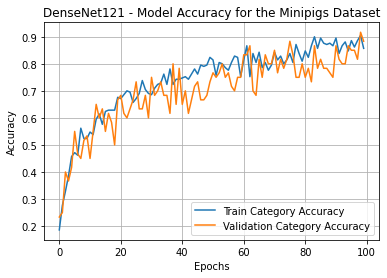

In [40]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
acc_title = "{} - Model Accuracy for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(acc_title)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Train Category Accuracy', 'Validation Category Accuracy'], loc='lower right')
plt.show()

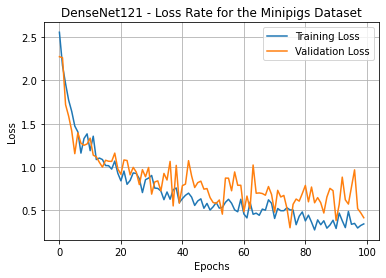

In [41]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
loss_title = "{} - Loss Rate for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(loss_title)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [42]:
train_loss, train_acc = model.evaluate(training_set, steps=16)
valid_loss, valid_acc = model.evaluate(valid_set, steps=16)

print('\nLearn Rate =', LEARN_RATE, ', Epochs =', EPOCHS, ', Training Folder =', TRAIN_PATH)

print('Validation Folder =', VALID_PATH, ', Test Folder =', TEST_PATH)

print('\nTraining: %.3f, Validation: %.3f' % (train_acc, valid_acc))

print('\nThe processing of Convolutional Neural Networks with Transfer Learning for', WHICH_MODEL, 'succeed.\n')

16/16 [==============================] - 12s 258ms/step - loss: 0.5949 - accuracy: 0.8833

Learn Rate = 0.0001 , Epochs = 100 , Training Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\train
Validation Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\val , Test Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\test

Training: 0.943, Validation: 0.883

The processing of Convolutional Neural Networks with Transfer Learning for DenseNet121 succeed.



In [43]:
results = model.evaluate(test_set, steps=16)
print("\nTest loss and accuracy are:", results)

16/16 [==============================] - 3s 32ms/step - loss: 0.5167 - accuracy: 0.7714

Test loss and accuracy are: [0.5166910886764526, 0.7714285850524902]


In [45]:
model.save('model_-15_0.2_100Epochs_v3.h5')